# Flash ID validation 
Jupyter notebook to look at a PMT based neutrino ID for the 

## Imports

In [28]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import glob
import time
from IPython.display import display, clear_output
import pandas as pd
import seaborn as sns
from operator import itemgetter

%matplotlib inline

## Constants

In [2]:
gr = 1.618
outdir= './output/'
inputdir = './input/'  

In [3]:
dict_names = ['nue','nu','on','off'] 

## Definitions

In [103]:
# Creates a dict with only a selection of keys from the original dict, given as a list ks
def subdict(d, ks):
    return dict(zip(ks, itemgetter(*ks)(d)))

def inTPC(row):
    if 0 < row['_nu_vtx_x'] < 256.35:
        if 0 < row['_nu_vtx_z'] < 1036.8:
            if -116.5 < row['_nu_vtx_y'] < 116.5:
                return True
    return False   

def inTPC_df(df, str_x, str_y, str_z):
    mask_x = df[str_x].between(0, 256.35)
    mask_y = df[str_y].between(-116.5, 116.5)
    mask_z = df[str_z].between(0, 1036.8)
    mask = mask_x & mask_y & mask_z
    return df[mask]

## Loading inputs

In [4]:
file_dict = {}
first = True
start = time.time()
for sample in dict_names:
    file_name = inputdir+'merge_'+sample+'.root'
    file = uproot.open(file_name)['pandoraFlashEventBuilding']
    file_dict[sample] = {}
    for tree_name in file.keys():
        name = tree_name.decode('UTF-8').split(';')[0]
        file_dict[sample][name] = file[tree_name].arrays(file[tree_name].keys())
        if first:
            print('*** ', name, ' ***')
            print(file[tree_name].keys())
            print()
    first = False
    print('Loaded',sample, 'sample.')

print('Loading took  {0:.2f} seconds.'.format(time.time()-start))

***  metadata  ***
[b'beamWindowStart', b'beamWindowEnd', b'minBeamFlashPE', b'maxDeltaY', b'maxDeltaZ', b'maxDeltaYSigma', b'maxDeltaZSigma', b'minChargeToLightRatio', b'maxChargeToLightRatio', b'chargeToNPhotonsTrack', b'chargeToNPhotonsShower']

***  events  ***
[b'run', b'subRun', b'event', b'nFlashes', b'nFlashesInBeamWindow', b'hasBeamFlash', b'nSlices', b'nSlicesAfterPrecuts', b'foundATargetSlice']

***  flashes  ***
[b'run', b'subRun', b'event', b'time', b'centerY', b'centerZ', b'widthY', b'widthZ', b'totalPE', b'peSpectrum', b'inBeamWindow', b'isBrightestInWindow', b'isBeamFlash']

***  slices  ***
[b'run', b'subRun', b'event', b'hasDeposition', b'totalCharge', b'centerX', b'centerY', b'centerZ', b'minX', b'deltaY', b'deltaZ', b'deltaYSigma', b'deltaZSigma', b'chargeToLightRatio', b'passesPreCuts', b'flashMatchScore', b'flashMatchX', b'totalPEHypothesis', b'peHypothesisSpectrum', b'isTaggedAsTarget', b'isConsideredByFlashId', b'topologicalScore', b'hasBestTopologicalScore', b'

## Quick checks

In [19]:
# Get the POT from the MC samples
pot_nue = sum(file_dict['nue']['subruns'][b'pot'])
print('Total POT in nue file: {0:.4g}'.format(pot_nue))
pot_nu = sum(file_dict['nu']['subruns'][b'pot'])
print('Total POT in nu file: {0:.4g}'.format(pot_nu))

Total POT in nue file: 4.686e+22
Total POT in nu file: 1.213e+20


In [20]:
# Be careful:
# Nue sample is all inside TPC, nu sample is in full cryostat!
# Tag2 MC, loads of events to not have slices!
# We have to correct the POT for this! assume having no slices is independent of anything else:
slice_scale_nue = sum(file_dict['nue']['events'][b'nSlices']>0)/len(file_dict['nue']['events'][b'nSlices'])
slice_scale_nu = sum(file_dict['nu']['events'][b'nSlices']>0)/len(file_dict['nu']['events'][b'nSlices'])

In [23]:
if 0: # Only run once if you dont know the number of pot and triggers yet
    # Get the run subrun list from data samples
    samples = ['on','off']
    for sample in samples:
        out_name = outdir + 'run_subrun_' + sample + '.txt'
        sun_subrun = np.array([file_dict[sample]['subruns'][b'run'], file_dict[sample]['subruns'][b'subRun']])
        np.savetxt(out_name, sun_subrun.T, fmt='%d')

triggers_off = 2428952
triggers_on = 1211556
pot_on = 5.194e+18

scale_off = triggers_on / triggers_off
scale_nu = pot_on / (pot_nu * slice_scale_nu)

In [12]:
sample= 'nue'
data = file_dict[sample]['events'][b'nFlashesInBeamWindow']
print('Events with flash in window: {0:.1f}%'.format(sum(data)/len(data)*100))
data = file_dict[sample]['events'][b'hasBeamFlash']
print('Events with flash in window and 50PE: {0:.1f}%'.format(sum(data)/len(data)*100))
nom = file_dict[sample]['events'][b'nSlicesAfterPrecuts']>0 
denom2 = file_dict[sample]['events'][b'nSlices']>0
print('Events passing the precuts: {0:.1f}%'.format(sum(nom)/sum(denom2)*100))

denom = (file_dict[sample]['slices'][b'completeness'] > 0.8) #& (file_dict['slices'][b'isConsideredByFlashId'])
nom = (file_dict[sample]['slices'][b'isTaggedAsTarget'])

print('Selected slice is most complete slice: {0:.1f}%'.format(sum(nom & denom)/sum(denom)*100))
print('Percentage of events with a complete neutrino slice: {0:.1f}%'.format(sum(denom)/sum(denom2)*100))

Events with flash in window: 79.2%
Events with flash in window and 50PE: 77.4%
Events passing the precuts: 61.7%
Selected slice is most complete slice: 75.1%
Percentage of events with a complete neutrino slice: 51.5%


In [13]:
# Masks
sample= 'nue'

slice_had_flash = file_dict[sample]['slices'][b'isConsideredByFlashId']
slice_has_charge = file_dict[sample]['slices'][b'hasDeposition']
mask = (slice_had_flash & slice_has_charge)

slice_pure = file_dict[sample]['slices'][b'completeness'] > 0.8
slice_not_pure = file_dict[sample]['slices'][b'completeness'] < 0.2
slice_complete = file_dict[sample]['slices'][b'purity'] > 0.8
slice_not_complete = file_dict[sample]['slices'][b'completeness'] < 0.2

mask_good = mask & slice_pure & slice_complete
mask_bad = mask & slice_not_pure & slice_not_complete

In [104]:
# We need to add the x, y, z, energy to the flashes, and select the one from the events with slices!
key_list = [b'run', b'subRun', b'event',
            b'nuInteractionType', b'nuEnergy', b'nuInteractionTime', b'nuPdgCode', 
            b'nuVertexX', b'nuVertexY', b'nuVertexZ']
df_genie_nue = pd.DataFrame.from_dict(subdict(file_dict['nue']['slices'], key_list)).drop_duplicates()
df_genie_nu = pd.DataFrame.from_dict(subdict(file_dict['nu']['slices'], key_list)).drop_duplicates()
df_genie_nu = inTPC_df(df_genie_nu, b'nuVertexX', b'nuVertexY', b'nuVertexZ')

key_list = list(file_dict['nue']['flashes'].keys())
key_list.remove(b'peSpectrum')
df_flashes_nue = pd.DataFrame.from_dict(subdict(file_dict['nue']['flashes'], key_list))
df_flashes_nu = pd.DataFrame.from_dict(subdict(file_dict['nu']['flashes'], key_list))

df_flashes_genie_nue = pd.merge(df_flashes_nue, df_genie_nue)
df_flashes_genie_nue.columns = [x.decode('UTF-8') for x in df_flashes_genie_nue.columns]

df_flashes_genie_nu = pd.merge(df_flashes_nu, df_genie_nu)
df_flashes_genie_nu.columns = [x.decode('UTF-8') for x in df_flashes_genie_nu.columns]

print(df_flashes_genie_nue.columns)

Index(['centerY', 'centerZ', 'event', 'inBeamWindow', 'isBeamFlash',
       'isBrightestInWindow', 'run', 'subRun', 'time', 'totalPE', 'widthY',
       'widthZ', 'nuEnergy', 'nuInteractionTime', 'nuInteractionType',
       'nuPdgCode', 'nuVertexX', 'nuVertexY', 'nuVertexZ'],
      dtype='object')


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f33a1760a58>]],
      dtype=object)

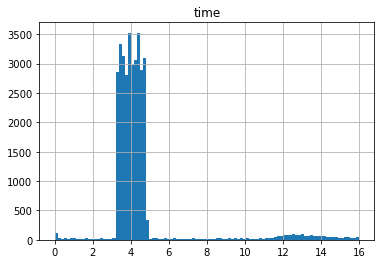

In [113]:
# Make the flash time and PE plot here!
df_flashes_genie_nu.hist('time', range=(0,16), bins=100)

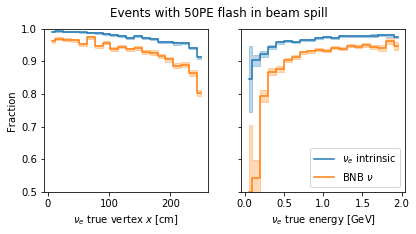

In [114]:
df_has_flash_nue = df_flashes_genie_nue.query("isBeamFlash==True")
df_has_flash_nu = df_flashes_genie_nu.query("isBeamFlash==True")

fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,3), sharey=True)

# Left
x_min = 0
x_max = 256
N = 21
edges = np.linspace(x_min,x_max,N)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
nom_bins, _ = np.histogram(df_has_flash_nue['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_genie_nue[b'nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
ax[0].step(edges_mid, fraq, where='mid')
ax[0].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')

nom_bins, _ = np.histogram(df_has_flash_nu['nuVertexX'], bins=edges)
denom_bins, _ = np.histogram(df_genie_nu[b'nuVertexX'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
ax[0].step(edges_mid, fraq, where='mid')
ax[0].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')

ax[0].set_xlabel(r'$\nu_e$ true vertex $x$ [cm]')


# Right
x_min = 0
x_max = 2
N = 21
edges = np.linspace(x_min,x_max,N)
edges_mid = [ edges[i]+(edges[i+1]-edges[i])/2 for i in range(N-1)]
nom_bins, _ = np.histogram(df_has_flash_nue['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_genie_nue[b'nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
ax[1].step(edges_mid, fraq, where='mid', label = r'$\nu_e$ intrinsic')
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C0')

nom_bins, _ = np.histogram(df_has_flash_nu['nuEnergy'], bins=edges)
denom_bins, _ = np.histogram(df_genie_nu[b'nuEnergy'], bins=edges)
fraq = nom_bins/denom_bins
err = np.sqrt( fraq*(1-fraq)/denom_bins )
ax[1].step(edges_mid, fraq, where='mid', label = r'BNB $\nu$')
ax[1].fill_between(edges_mid, fraq - err, fraq + err, alpha=0.3, step='mid', color='C1')

ax[1].legend()
ax[1].set_xlabel(r'$\nu_e$ true energy [GeV]')

fig.suptitle('Events with 50PE flash in beam spill')
ax[0].set_ylabel('Fraction')
ax[0].set_ylim(0.5,1)
ax[1].set_ylim(0.5,1)

fig.savefig( outdir+"flash_eff_nue.pdf", bbox_inches="tight")

## Plots

In [14]:
# Plots 
plot_fields = [b'deltaZ', b'deltaZSigma', b'deltaY', b'deltaYSigma', b'chargeToLightRatio']
plot_x_axis = [r"Charge $z$ - Flash $z$ [cm]", "(Charge $z$ - Flash $z$) / Flashwidth $z$",
               r"Charge $y$ - Flash $y$ [cm]", "(Charge $y$ - Flash $y$) / Flashwidth $y$"]

x_min_arr =  [-200,-1.8,-120,-4.0]
x_max_arr =  [150,1.4,120,4.0]
bins_arr = [30,30,30,30]
y_max_arr = [0.033,4.0,0.013,0.55]
y_max_2_arr = [6000,6500,8200,11500]
cut_arr = [105,1.0,95,2.1]


0.9628212871619355
0.9802697805516408
0.9937252533387021
0.9707737735722435


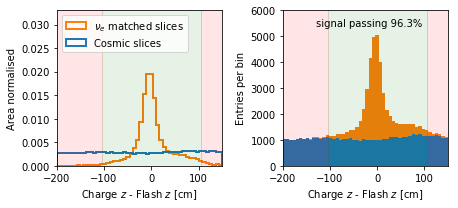

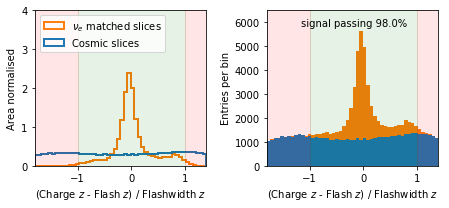

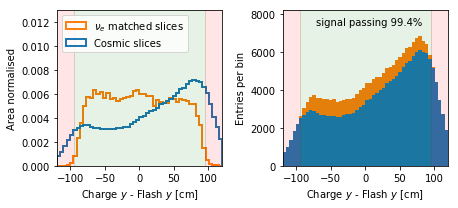

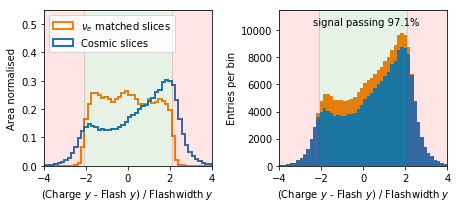

In [15]:
# Plotter
for field,x_axis, x_min, x_max, bins, y_max, y_max2, cut in zip(plot_fields, plot_x_axis, x_min_arr, x_max_arr, bins_arr, y_max_arr, y_max_2_arr ,cut_arr):
    
    fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,3), sharex=True)
    
    data = file_dict[sample]['slices'][field]
    
    #Ratio of good slices kept by this cut:
    mask_cut = (data>-cut) & (data<cut)
    ratio_kept = sum(mask_good & mask_cut)/sum(mask_good)
    print(ratio_kept)
    mask_g_temp = mask_good[(data>x_min) & (data<x_max)]
    mask_b_temp = mask_bad[(data>x_min) & (data<x_max)]
    data = data[(data>x_min) & (data<x_max)]
    
    ax[0].hist([data[mask_b_temp],data[mask_g_temp]],bins=50, label=['Cosmic slices', r'$\nu_e$ matched slices'], histtype='step', lw=2, density=1)
    ax[1].hist([data[mask_b_temp],data[mask_g_temp]],bins=50, label=['Cosmic slices', r'$\nu_e$ matched slices'], histtype='barstacked')
    ax[0].set_xlabel(x_axis)
    ax[1].set_xlabel(x_axis)
    ax[1].set_ylabel('Entries per bin')
    ax[0].set_ylabel('Area normalised')
    ax[0].legend(loc='upper left')
    ax[0].set_ylim(0,y_max)
    ax[1].set_ylim(0,y_max2)
    ax[0].set_xlim(x_min,x_max)
    ax[0].axvspan(x_min,-cut, alpha=0.1, color="red")
    ax[0].axvspan(-cut,cut, alpha=0.1, color="green")
    ax[0].axvspan(cut,x_max, alpha=0.1, color="red")
    ax[1].axvspan(x_min,-cut, alpha=0.1, color="red")
    ax[1].axvspan(-cut,cut, alpha=0.1, color="green")
    ax[1].axvspan(cut,x_max, alpha=0.1, color="red")
    
    text_x = x_min+(x_max-x_min)*0.2
    ax[1].text(text_x, y_max2*0.9, 'signal passing {0:.1f}%'.format(ratio_kept*100))
    
    fig.tight_layout()
    fig.savefig( outdir+field.decode('UTF-8')+".pdf")

0.9817126367357896


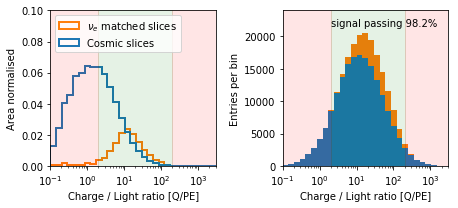

In [16]:
# make charge light ratio plot!
fig,ax=plt.subplots(ncols=2,nrows=1,figsize=(4*gr,3), sharex=True)


x_min = 0.1
x_max = 3000
N=30
bhalf = (x_max-x_min)/(2*N)
edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
cut = 3.0
y_max = 0.1
y_max2= 24000
x_axis = r"Charge / Light ratio [Q/PE]"
field = b'chargeToLightRatio'
data = file_dict[sample]['slices'][field]

#Ratio of good slices kept by this cut:
mask_cut = (data>2) & (data<200)
ratio_kept = sum(mask_good & mask_cut)/sum(mask_good)
print(ratio_kept)
mask_g_temp = mask_good[(data>x_min) & (data<x_max)]
mask_b_temp = mask_bad[(data>x_min) & (data<x_max)]
data = data[(data>x_min) & (data<x_max)]

edges=np.logspace(np.log10(x_min),np.log10(x_max), N)
ax[0].hist([data[mask_b_temp],data[mask_g_temp]],bins=edges, label=['Cosmic slices', r'$\nu_e$ matched slices'], histtype='step', lw=2, density=1)
ax[1].hist([data[mask_b_temp],data[mask_g_temp]],bins=edges, label=['Cosmic slices', r'$\nu_e$ matched slices'], histtype='barstacked')

ax[0].set_xlabel(x_axis)
ax[1].set_xlabel(x_axis)
ax[1].set_ylabel('Entries per bin')
ax[0].set_ylabel('Area normalised')
ax[0].legend(loc='upper left')
ax[0].set_ylim(0,y_max)
ax[1].set_ylim(0,y_max2)
ax[0].set_xlim(x_min,x_max)
ax[0].axvspan(x_min,2, alpha=0.1, color="red")
ax[0].axvspan(2,200, alpha=0.1, color="green")
ax[0].axvspan(200,x_max, alpha=0.1, color="red")
ax[1].axvspan(x_min,2, alpha=0.1, color="red")
ax[1].axvspan(2,200, alpha=0.1, color="green")
ax[1].axvspan(200,x_max, alpha=0.1, color="red")
ax[1].set_xscale("log", nonposx='clip') 
ax[0].set_xscale("log", nonposx='clip') 

text_x = 2
ax[1].text(text_x, y_max2*0.9, 'signal passing {0:.1f}%'.format(ratio_kept*100))

fig.tight_layout()
fig.savefig( outdir+field.decode('UTF-8')+".pdf")